# Homework 4

## Mysql-Python Connection

In [53]:
import mysql.connector
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import csv

%matplotlib inline

In [54]:
db_connection = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="root", # change password
  auth_plugin='mysql_native_password'
)
print(db_connection)

In [55]:
# creating database_cursor to perform SQL operation to run queries
db_cursor = db_connection.cursor(buffered=True)
    

In [56]:
# Drop the database before creating same one. If your machine already has this db, you can uncomment the following code,
# and run to clear existing db.
# db_cursor.execute("DROP DATABASE ps_ecommerce")

In [57]:
# executing cursor with execute method and pass SQL query
db_cursor.execute("CREATE DATABASE ps_ecommerce")

# get list of all databases
db_cursor.execute("SHOW DATABASES")

# print all databases
for db in db_cursor:
    print(db)

('information_schema',)
('mysql',)
('performance_schema',)
('ps_ecommerce',)
('sys',)
('testdb',)
('world',)


In [58]:
db_cursor.execute("USE ps_ecommerce")

## Load Data to Mysql Tables

In [59]:
def populate_table(db_connection, db_cursor, insert_query, file_path):
    
    with open(file_path, mode='r') as csv_data:
        reader = csv.reader(csv_data, delimiter=';')
        csv_data_list = list(reader)
        for row in csv_data_list[1:]:
            row = tuple(map(lambda x: None if x == "" else x, row[0].split(',')))
            db_cursor.execute(insert_query, row)
        
    db_connection.commit()

In [60]:
# create CUSTOMERS table
db_cursor.execute("""CREATE TABLE CUSTOMERS (customer_id VARCHAR(50) NOT NULL, 
                                          customer_unique_id VARCHAR(50) NOT NULL, 
                                          customer_zip_code_prefix VARCHAR(50), 
                                          customer_city VARCHAR(50), 
                                          customer_state VARCHAR(50))""")

insert_customers = (
    "INSERT INTO CUSTOMERS(customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_customers, "customers.csv")

In [61]:
# create ORDER_PAYMENTS table
db_cursor.execute("""CREATE TABLE ORDER_PAYMENTS (order_id VARCHAR(50) NOT NULL, 
                                          payment_sequential INTEGER, 
                                          payment_type VARCHAR(50), 
                                          payment_installments INTEGER, 
                                          payment_value FLOAT)""")

insert_orderpayments = (
    "INSERT INTO ORDER_PAYMENTS(order_id, payment_sequential, payment_type, payment_installments, payment_value) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderpayments, "order_payments.csv")

In [62]:
# create ORDER_ITEMS table
db_cursor.execute("""CREATE TABLE ORDER_ITEMS (order_id VARCHAR(50) NOT NULL, 
                                          order_item_id INTEGER, 
                                          product_id VARCHAR(50), 
                                          seller_id VARCHAR(50), 
                                          shipping_limit_date DATETIME,
                                          price FLOAT,
                                          freight_value FLOAT)""")

insert_orderitems = (
    "INSERT INTO ORDER_ITEMS(order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderitems, "order_items.csv")

In [63]:
# create ORDERS table
db_cursor.execute("""CREATE TABLE ORDERS (order_id VARCHAR(50) NOT NULL, 
                                          customer_id VARCHAR(50) NOT NULL, 
                                          order_status VARCHAR(50), 
                                          order_purchase_timestamp DATETIME, 
                                          order_approved_at DATETIME,
                                          order_delivered_carrier_date DATETIME,
                                          order_delivered_customer_date DATETIME,
                                          order_estimated_delivery_date DATETIME)""")

insert_orders = (
    "INSERT INTO ORDERS(order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orders, "orders.csv")

## Question 1 (10 pts)

In [64]:
# Find the average number of weeks between products' actual delivery dates and estimated delivery dates. 
# Use order_delivered_customer_date column as actual delivery dates and 
# order_estimated_delivery_date column as estimated delivery dates.

# HINT: There is a function in MySQL that makes it easy to compute the difference between two timestamps.
# We recommend that you search for it online and use it in your answer.

In [65]:
# Is 4 days counted as 0 weeks, or is it counted as 4/7 weeks?
# Code below counts for the case it counts as 4/7 weeks.

# db_cursor.execute("""SELECT AVG(TIMESTAMPDIFF(day, orders.order_delivered_customer_date, orders.order_estimated_delivery_date) / 7)
#                     FROM orders
#                         """)

# The following code is for the case (i.e) 4 days counted as 0 weeks.
db_cursor.execute("""SELECT AVG(TIMESTAMPDIFF(week, orders.order_delivered_customer_date, orders.order_estimated_delivery_date))
                    FROM orders
                        """)

avg_number_of_weeks = db_cursor.fetchall()

In [66]:
avg_diff_weeks = list(avg_number_of_weeks)[0][0]
print(avg_diff_weeks)

1.1862


## Question 2 (15 pts)

In [67]:
# Consider the ORDER_COSTS table below. Using this table and the CUSTOMERS table, find the following:
# In which states do customers spend, on average, more than 164 on their orders? 
# Fetch those states and average order costs in those states. Results should be ordered from lowest cost to highest.

In [68]:
order_costs_query = """
                    CREATE TABLE ORDER_COSTS AS (
                        SELECT ORDERS.order_id, SUM(price) AS cost, ORDERS.customer_id as cid
                        FROM ORDER_ITEMS 
                             JOIN ORDERS
                             ON ORDER_ITEMS.order_id=ORDERS.order_id
                        GROUP BY order_id, ORDERS.customer_id)
                    """

db_cursor.execute(order_costs_query)

In [69]:
# Solve Question 2 below
db_cursor.execute("""SELECT AVG(cost) as average , c.customer_state as state
                    FROM order_costs, customers as c
                    WHERE cost > 0 and order_costs.cid = c.customer_id
                    GROUP BY c.customer_state
                    HAVING average > 164
                    ORDER BY AVG(cost) ASC""")

state_avg_above_164 = db_cursor.fetchall()

In [70]:
average, state = map(list, zip(*state_avg_above_164))
print(average)
print(state)

[165.95715586927687, 168.72618171229507, 173.50979253761005, 179.9429249493581, 182.85564198849806, 184.82068734097837, 202.31006200565315, 217.85388387291178, 222.1680950891404, 224.56719970703125, 279.38705960442036]
['PE', 'RN', 'MS', 'TO', 'PA', 'MT', 'AL', 'RO', 'PB', 'AC', 'RR']


## Question 3 (15 pts)

In [71]:
# Implement the following function get_month. It takes as input a month as an integer.
# It needs to compute: In the given month, how many payments were made with each different payment type?
# e.g.: Credit card -> 5000 payments, debit card -> 100 payments, voucher -> 300 payments, ...

# HINT: One of the MySQL functions we covered in the PS makes it easy to work with months.

In [72]:
# Solve Question 3 below

def get_month(month):
    
    query = """SELECT COUNT(ORDERS.order_id), payment_type
                FROM ORDERS, order_payments
                where orders.order_id = order_payments.order_id and MONTH(ORDERS.order_purchase_timestamp) =  {} 
                GROUP BY payment_type
    """.format(month)
#     print(query)
    db_cursor.execute(query)
    items = db_cursor.fetchall()
    return items

In [73]:
# Here is a sample function call for get_month:
print(get_month("2"))

[(6609, 'credit_card'), (1723, 'boleto'), (424, 'voucher'), (82, 'debit_card')]


## Question 4 (10 pts)

In [74]:
# Consider the PRODUCTS table below and the ORDER_ITEMS table from earlier. 
# For each product category other than {"moveis_decoracao", "beleza_saude"}, find the minimum price that was paid for
# an item from that category. Limit the result to retrieve only 6 rows.

# The result should be like: category1 -> minprice1, category2 -> minprice2, ...

In [75]:
# db_cursor.execute("DROP TABLE PRODUCTS")

In [76]:
db_cursor.execute("""CREATE TABLE PRODUCTS (product_id VARCHAR(50) NOT NULL, 
                                            product_category_name VARCHAR(50), 
                                            product_name_lenght INTEGER, 
                                            product_description_lenght INTEGER, 
                                            product_photos_qty INTEGER,
                                            product_weight_g INTEGER,
                                            product_length_cm INTEGER,
                                            product_height_cm INTEGER,
                                            product_width_cm INTEGER)""")

insert_products = (
    "INSERT INTO PRODUCTS(product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm,  product_height_cm, product_width_cm) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_products, "products.csv")

In [77]:
# Solve Question 4 below

# It was not required to order by, but I did for convenience.
db_cursor.execute("""SELECT p.product_category_name, MIN(price) as min_price
                    FROM products p, order_items o
                    WHERE o.product_id = p.product_id
                    group by p.product_category_name
                    having p.product_category_name != "moveis_decoracao" and p.product_category_name != "beleza_saude" 
                    order by min_price
                    LIMIT 6""")

category_min_price = db_cursor.fetchall()

In [78]:
print(category_min_price)
category, min_price = map(list, zip(*category_min_price))
print("#######")
for i in range(len(category)):
    print(category[i], "->", min_price[i])

[('bebes', 3.54), ('informatica_acessorios', 3.9), ('fashion_underwear_e_moda_praia', 3.9), ('papelaria', 4.2), ('utilidades_domesticas', 4.4), ('instrumentos_musicais', 4.9)]
#######
bebes -> 3.54
informatica_acessorios -> 3.9
fashion_underwear_e_moda_praia -> 3.9
papelaria -> 4.2
utilidades_domesticas -> 4.4
instrumentos_musicais -> 4.9


## Question 5 (10 pts)

In [79]:
# Draw a pie chart using the data from the previous question.
# Labels of your pie chart should be the product categories.
# Contents of your pie chart (i.e., sizes of the pie slices) should be determined by the min prices.

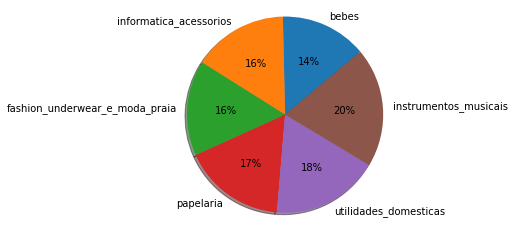

In [80]:
# Solve Question 5 below
explode = [0.0 for _ in range(len(category))]
fig1, ax1 = plt.subplots()
ax1.pie(min_price, explode=explode, labels=category, autopct='%1.0f%%', shadow=True, startangle=40)
ax1.axis('equal') 
plt.show()

## Question 6 (15 pts)

In [81]:
# Let us define "large products" as those products with weight > 400 and length > 10.
# Some orders that contain a large product can have large discrepancies between their order_delivered_carrier_date and 
# order_delivered_customer_date. 
# Let us define "strange orders that contain large products" as those orders which contain a large product and the 
# difference between their order_delivered_carrier_date and order_delivered_customer_date is larger than 100 days.

# For all "strange orders that contain large products", find their order IDs and the number of days difference between 
# their order_delivered_carrier_date and order_delivered_customer_date.
# Result should be like: "abc21312df" -> 32, "dhs230kdf8" -> 29, ...

# HINT: Using the same MySQL function as Question 1 may help.

In [82]:
# Solve Question 6 below

db_cursor.execute("""SELECT DISTINCT order_items.order_id, DATEDIFF(o.order_delivered_customer_date,o.order_delivered_carrier_date) as date_diff
                    from orders o, order_items
                    where DATEDIFF(o.order_delivered_customer_date,o.order_delivered_carrier_date) > 100 and o.order_id = order_items.order_id and order_items.product_id IN(
                    (SELECT p.product_id
                    from products p
                    where p.product_weight_g > 400 and p.product_length_cm > 10) 
                    )""")

large_strange_products = db_cursor.fetchall()



In [83]:
# print(large_strange_products)
order_id, date_diff = map(list, zip(*large_strange_products))
print("#######")
for i in range(len(order_id)):
    print(order_id[i], "->", date_diff[i])

#######
6e3a1f3ec46461756c3f620e267aa1b8 -> 103
d24e8541128cea179a11a65176e0a96f -> 171
3b919fbc512d96f81330d2aae3ed0cf6 -> 106
0f4519c5f1c541ddec9f21b3bddd533a -> 181
e52c9dfec957c503bed5d050a39c740f -> 103
031e7d4e559a1bf08e71a419aa998d0a -> 165
437222e3fd1b07396f1d9ba8c15fba59 -> 182
525e11b26fdb7f41471d289897d0f6da -> 167
47b40429ed8cce3aee9199792275433f -> 157
1b3190b2dfa9d789e1f14c05b647a14a -> 205
2ba1366baecad3c3536f27546d129017 -> 179
dfe5f68118c2576143240b8d78e5940a -> 182
0b32bf55276b5feb681f6ed6fd670692 -> 143
d8dbb44d7c5b1fd8e7f41b49e27053d7 -> 104
cce224811ba8fea016c049693c3e0402 -> 146
6e82dcfb5eada6283dba34f164e636f5 -> 181
160d1364f477494647a995f6bbec0b5f -> 105
7e708aed151d6a8601ce8f2eaa712bf4 -> 135
a4efaffc506a395c9cea7402b078c1e5 -> 103


## Question 7 (10 pts)

In [84]:
# Draw a bar chart using the data from the previous question.
# Order IDs should be on the x-axis.
# Number of days difference should be on the y-axis.
# (Although we are not looking for production quality figures, make sure that your plots are readable.)

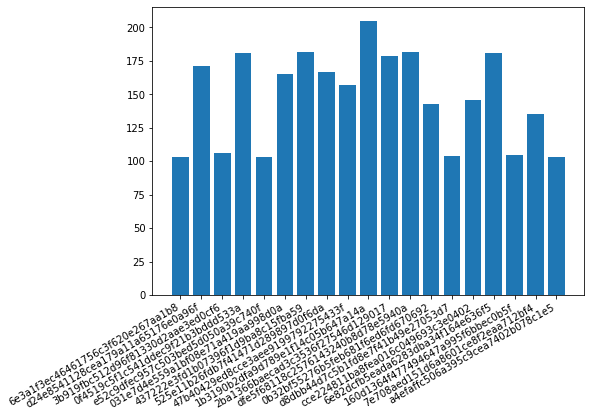

In [85]:
# Solve Question 7 below
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order_id, date_diff)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## Question 8 (15 pts)

In [86]:
# Write an SQL query to find the total number of orders per week day, e.g., Monday -> 150 orders, Tuesday -> 200 orders,
# Wednesday -> 500 orders, etc. Use the "order_purchase_timestamp" attribute when counting the number of orders.
# Plot the result using a bar chart (days of week on x-axis, number of orders on y-axis). 

# HINT: Check out the "WEEKDAY" function of MySQL. 

In [87]:
# Solve Question 8 below

db_cursor.execute("""
                    SELECT WEEKDAY(o.order_purchase_timestamp) as weekdays, COUNT(o.order_id)
                    from orders o
                    group by weekdays""")
weekday_order = db_cursor.fetchall()



In [88]:
weekday, order = map(list, zip(*weekday_order))
print(weekday, order)

[0, 1, 2, 5, 6, 3, 4] [16196, 15963, 15552, 10887, 11960, 14761, 14122]


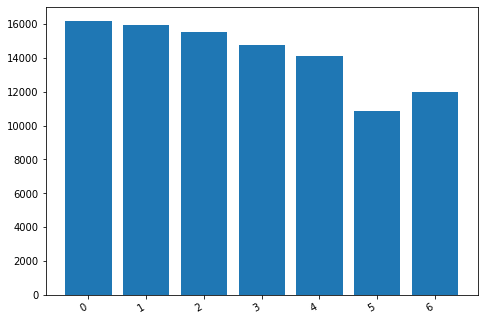

In [89]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(weekday, order)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [90]:
db_cursor.close()
db_connection.close()